In [1]:
import pandas as pd
import requests
import yfinance as yf
import datetime as dt
import numpy as np
from bs4 import BeautifulSoup

In [2]:
html = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = BeautifulSoup(html.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

In [3]:
stock_data = pd.read_html(str(table))[0]
names = [name.replace(".", "-") for name in stock_data.Symbol]
name_query = " ".join(names)

In [4]:
delta_t = pd.tseries.offsets.BusinessDay(n = 21)
end_date = dt.date.today()
start_date = end_date - delta_t

In [5]:
px = yf.download(name_query, start=start_date)

[*********************100%***********************]  503 of 503 completed


In [6]:
chain_slug = f'https://api.polygon.io/v3/snapshot/options/'

In [35]:
df = pd.DataFrame()
for ticker in names:

    query_url = chain_slug + ticker + '/'
    spot = px['Adj Close'][ticker].iloc[-1]

    low_strike = 0.8 * spot
    high_strike = 1.2 * spot

    payload = {'expiration_date': '2023-01-20', 'strike_price.gte': low_strike, 
    'strike_price.lte': high_strike, 'limit': 100}

    r = requests.get(query_url, headers={"Authorization": ""}, params = payload)

    dict_results = dict(r.json())

    for contract in dict_results['results']:

        expiries = [contract['details'].get('expiration_date', np.nan) for contract in dict_results['results']]
        strikes = [contract['details'].get('strike_price', np.nan) for contract in dict_results['results']]
        deltas = [contract['greeks'].get('delta', np.nan) for contract in dict_results['results']]
        call_puts = [contract['details'].get('contract_type', np.nan) for contract in dict_results['results']]
        opt_style = [contract['details'].get('exercise_style', np.nan) for contract in dict_results['results']]
        spots = [contract['day'].get('close', np.nan) for contract in dict_results['results']]
        volumes = [contract['day'].get('volume', np.nan) for contract in dict_results['results']]
        update = [contract['day'].get('last_updated', np.nan) for contract in dict_results['results']]

        px_ticker = [spot for contract in dict_results['results']]


        t_df = pd.DataFrame({'expiry': expiries, 'strike': strikes, 'delta': deltas,
        'callput': call_puts, 'style': opt_style, 'spot': spots, 'volume': volumes, 'update':update, 'px': px_ticker})

        t_df['ticker'] = ticker
        t_df['k_norm'] = strikes / spot

    df = pd.concat([df, t_df])

In [36]:
date_list = []
delta_list = []
today = dt.date.today()

for date in df['update']:

    try:

        t_dt = dt.datetime.fromtimestamp(date // 1000000000)
        date_list.extend([t_dt])

        delta = (today - t_dt.date()).days
        delta_list.extend([delta])


    except:

        date_list.extend([np.nan])
        delta_list.extend([np.nan])

df['expiry_days'] = (today - t_dt.date()).days
df['update_dt'] = date_list
df['delta_days'] = delta_list
df['isLive'] = df['delta_days'].apply(lambda x: (x < 14))

In [37]:
df['delta'] = df.delta.mask(~df.isLive)

In [38]:
df

,expiry,strike,delta,callput,style,spot,volume,update,px,ticker,k_norm,expiry_days,update_dt,delta_days,isLive
0,2023-01-20,105.0,0.966272,call,american,20.25,1,1.672866e+18,129.350006,MMM,0.811751,28,2023-01-04 21:00:00,9.0,True
1,2023-01-20,108.0,NaN,call,american,0.00,0,NaN,129.350006,MMM,0.834944,28,NaT,NaN,False
2,2023-01-20,109.0,NaN,call,american,0.00,0,NaN,129.350006,MMM,0.842675,28,NaT,NaN,False
3,2023-01-20,110.0,0.944287,call,american,17.84,2,1.673298e+18,129.350006,MMM,0.850406,28,2023-01-09 21:00:00,4.0,True
4,2023-01-20,111.0,NaN,call,american,0.00,0,NaN,129.350006,MMM,0.858137,28,NaT,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,2023-01-20,170.0,-0.854710,put,american,10.20,24,1.673482e+18,159.910004,ZTS,1.063098,28,2023-01-12 00:00:00,1.0,True
22,2023-01-20,175.0,NaN,put,american,47.50,10,1.667506e+18,159.910004,ZTS,1.094366,28,2022-11-03 20:00:00,71.0,False
23,2023-01-20,180.0,NaN,put,american,20.70,1,1.673482e+18,159.910004,ZTS,1.125633,28,2023-01-12 00:00:00,1.0,True
24,2023-01-20,185.0,NaN,put,american,36.70,75,1.669842e+18,159.910004,ZTS,1.156901,28,2022-11-30 21:00:00,44.0,False


In [39]:
d_curve = df[df['callput'] == 'call']
rebase_index = np.arange(0.8,1.21,0.001)

In [40]:
curves = pd.DataFrame()

curve_df = pd.DataFrame(columns = names, index = rebase_index)

for tick in names:
    
    t_curve = d_curve[d_curve['ticker'] == tick][['k_norm', 'delta']].set_index('k_norm')

    try:    
        interp_curve = pd.DataFrame(np.interp(rebase_index, t_curve.index, t_curve.delta), index = rebase_index)
        curve_df[tick] = interp_curve

    except:

        pass

<AxesSubplot: >

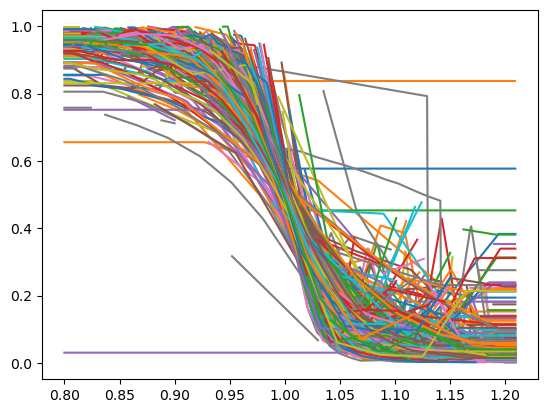

In [41]:
curve_df.plot(legend=False)